# Unet for steel defect image segementation part 1 (EDA and modelling)
# IDML 2 project by Fahad Deshmukh



## EDA

In [2]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
#print(os.listdir("../input/severstal-steel-defect-detection/"))
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm import tqdm
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
#os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:

!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null # no output
package_path = '/kaggle/input/unetmodelscript' # add unet script dataset
import sys
sys.path.append(package_path)
from model import Unet # import Unet model from the script

In [5]:
train_df=pd.read_csv("/kaggle/input/steelsudo1/sudo.csv")
train_path = Path("/kaggle/input/severstal-steel-defect-detection/train_images/")

In [6]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [14]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


defaultdict(int, {1: 6239, 0: 5902, 2: 425, 3: 2})

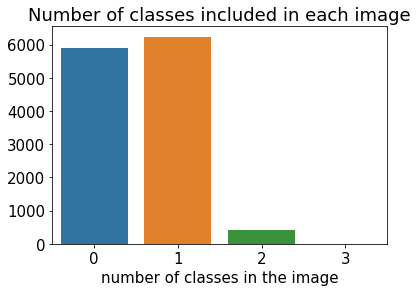

In [16]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

defaultdict(int, {1: 897, 3: 5150, 4: 801, 2: 247})

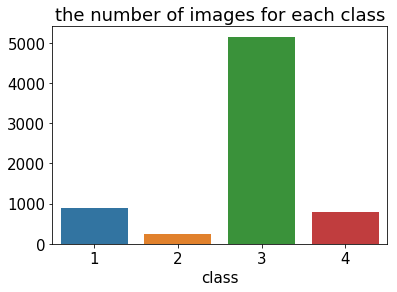

In [15]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict

In [17]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

In [18]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

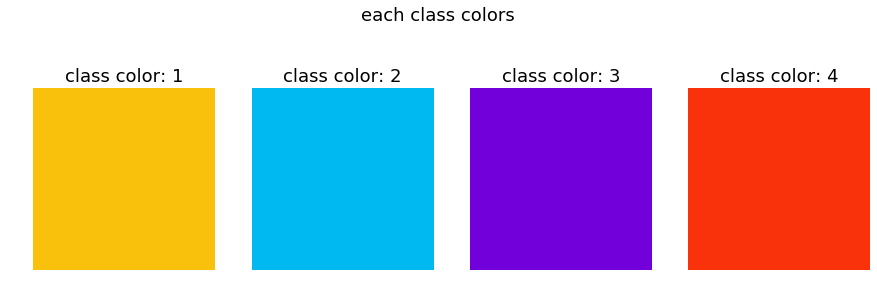

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [41]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)

### Images without any defect

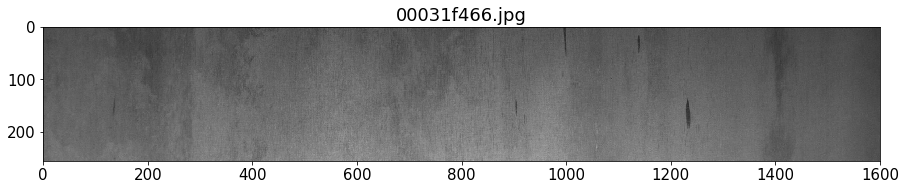

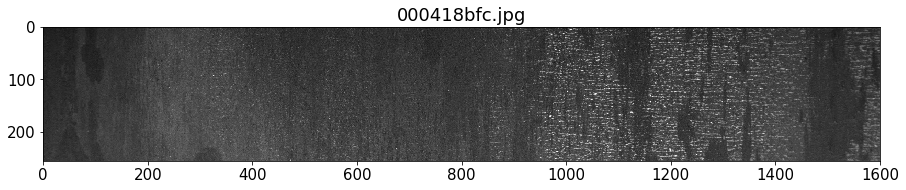

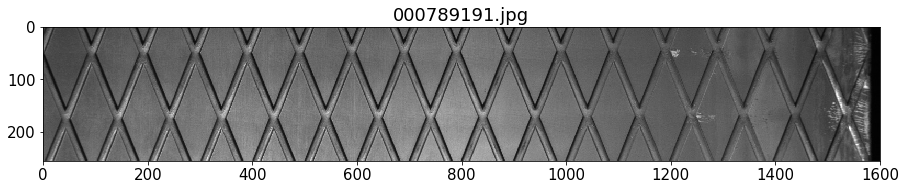

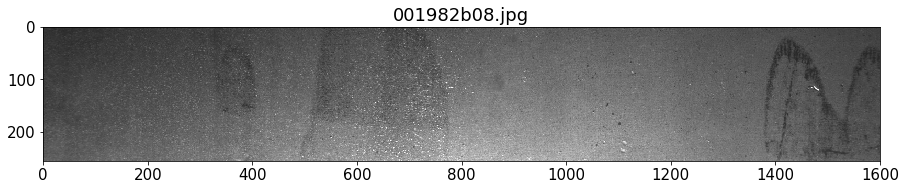

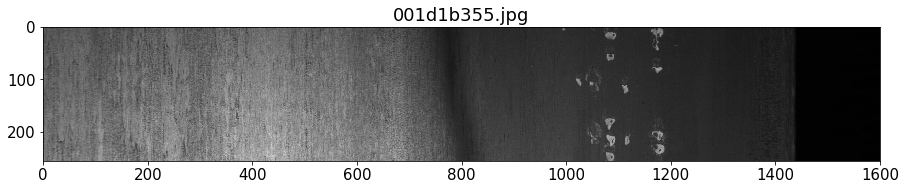

In [45]:
for idx in idx_no_defect[:5]:
    show_mask_image(idx)

### Images of type I defect

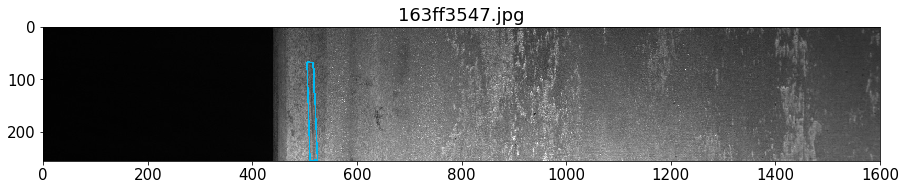

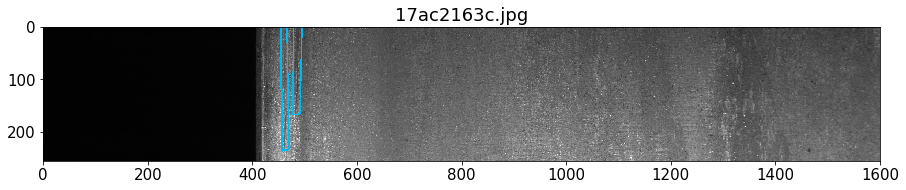

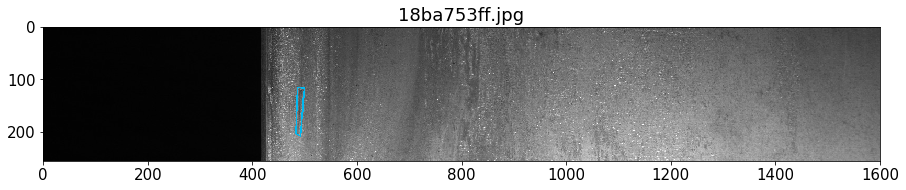

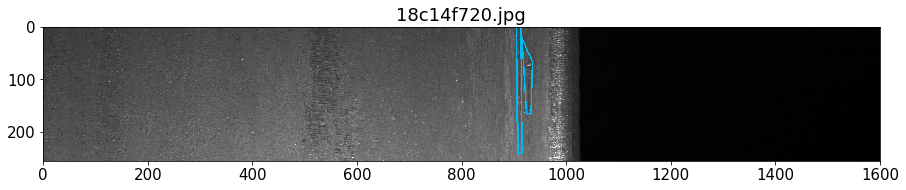

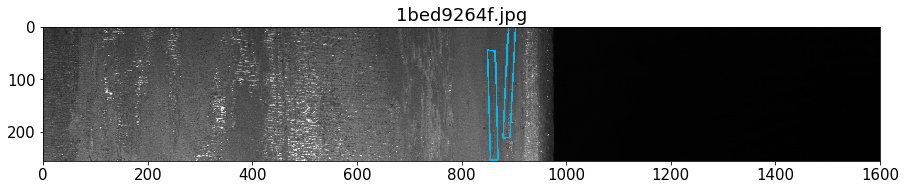

In [46]:
for idx in idx_class_2[21:26]:
    show_mask_image(idx)

### Images of Type II defect

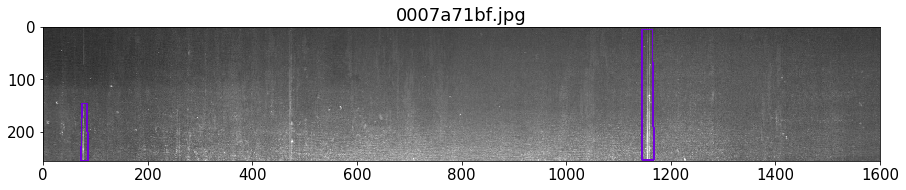

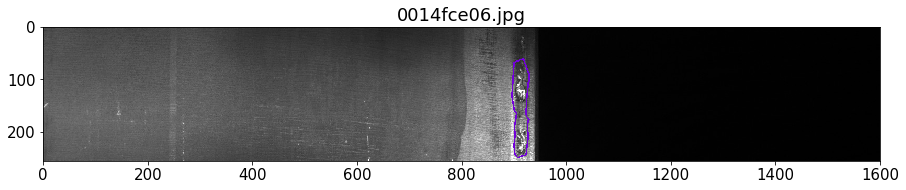

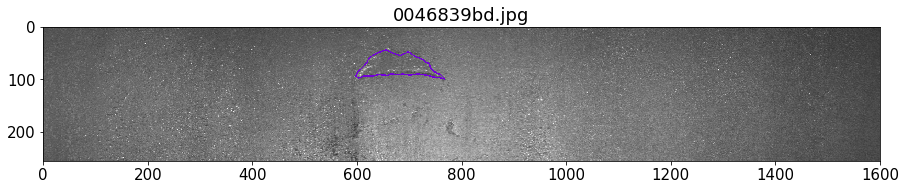

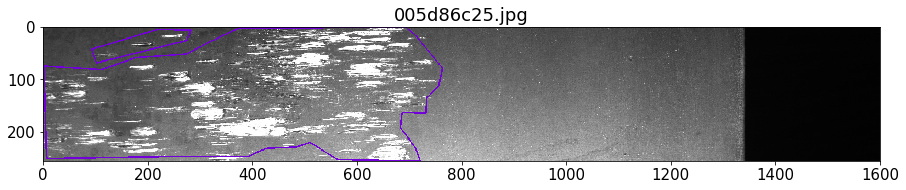

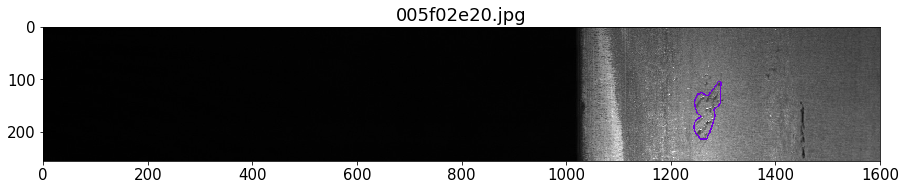

In [47]:
for idx in idx_class_3[:5]:
    show_mask_image(idx)

### Images wit type III defect

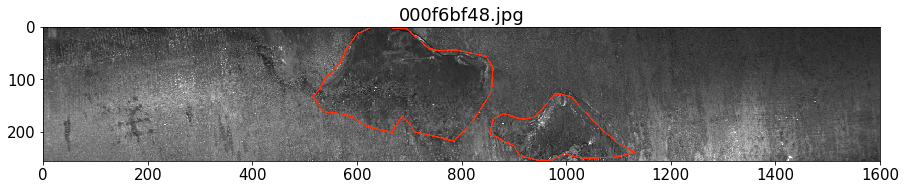

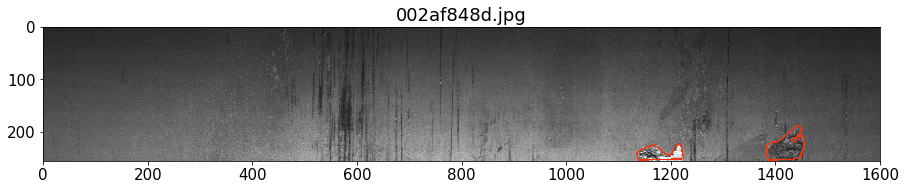

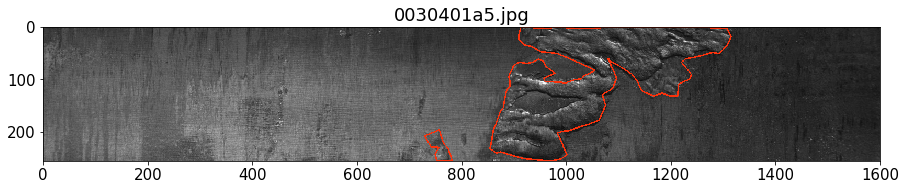

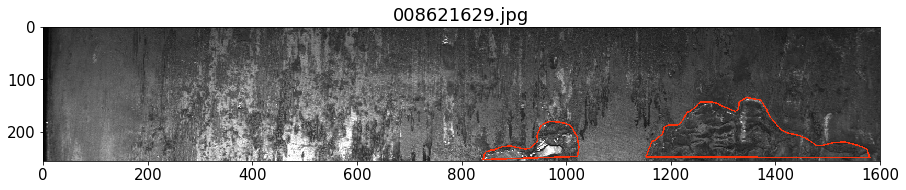

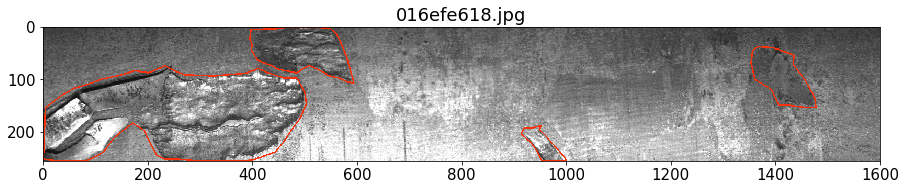

In [48]:
for idx in idx_class_4[:5]:
    show_mask_image(idx)

### Images with more than one toe of defect

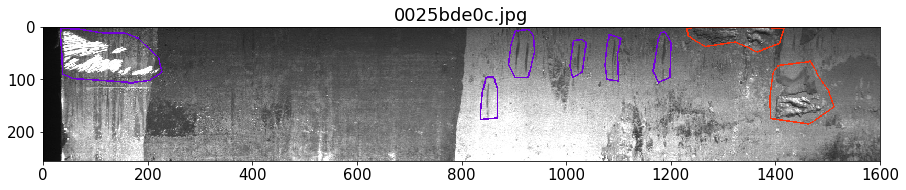

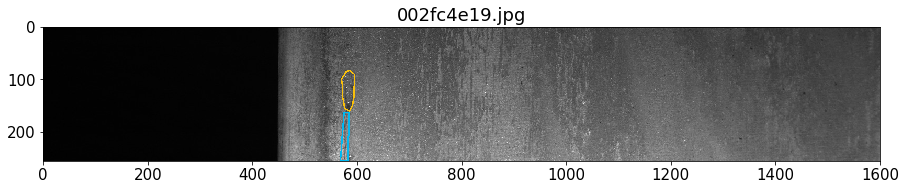

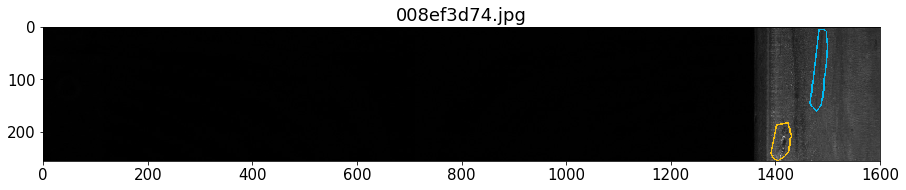

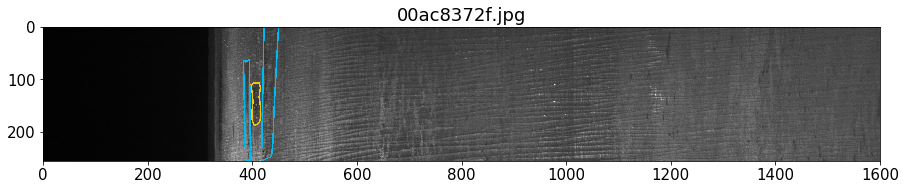

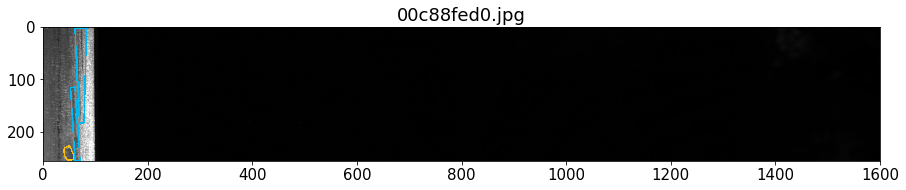

In [49]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)

## RLE-Mask utility functions

#### Helper functions for RUn-length ecoding and mask generation.

In [4]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Dataloader + augmentations

In [5]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader


## Some more utility functions

Dice and IoU metric implementations, metric logger for training and validation.

In [6]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## Modelling uisng Unet

## BAseline model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))

class SimpleEncoder(nn.Module):
    """A very simple encoder with two convolutional layers."""
    def __init__(self):
        super().__init__()
        self.conv1 = SimpleConvBlock(3, 64)  # Assuming input is RGB
        self.conv2 = SimpleConvBlock(64, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        return x

class SimpleDecoder(nn.Module):
    """A very simple decoder."""
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv1 = SimpleConvBlock(128, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.final_conv(x)

class SimpleUNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = SimpleEncoder()
        self.decoder = SimpleDecoder(num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
# Intialization

base_model = SimpleUNet(num_classes=4) 

## Model Initialization

In [13]:
base_model

SimpleUNet(
  (encoder): SimpleEncoder(
    (conv1): SimpleConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (conv2): SimpleConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
  )
  (decoder): SimpleDecoder(
    (conv1): SimpleConvBlock(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (final_conv): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [13]:
# Loading pre-trained resent18
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp ../input/resnet18/resnet18.pth /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth

In [26]:
resnet18_weights_path = "/kaggle/input/resnet18/resnet18.pth"
resnet18 = torch.load(resnet18_weights_path)

In [27]:
model = Unet("resnet18", encoder_weights=None, classes=4, activation=None)


In [28]:
model.encoder.load_state_dict(resnet18)

In [11]:
model # uncomment to take a deeper look

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Training and Validation

In [20]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 5
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model0.pth")
            print()


In [18]:
sample_submission_path = '../input/severstal-steel-defect-detection/sample_submission.csv'
train_df_path = '/kaggle/input/steelsudo1/sudo.csv'
data_folder = "../input/severstal-steel-defect-detection/"
test_data_folder = "../input/severstal-steel-defect-detection/test_images"

### Training baseline model

In [21]:
# Instantiate the Trainer with the SimpleCNN model
base_trainer = Trainer(base_model)

# Start training
base_trainer.start()


Starting epoch: 0 | phase: train | ⏰: 14:01:19
Loss: 0.0363 | IoU: 0.0082 | dice: 0.2555 | dice_neg: 0.5274 | dice_pos: 0.0148
Starting epoch: 0 | phase: val | ⏰: 14:11:03
Loss: 0.0368 | IoU: 0.0385 | dice: 0.1582 | dice_neg: 0.2616 | dice_pos: 0.0665
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 14:12:49
Loss: 0.0353 | IoU: 0.0088 | dice: 0.2964 | dice_neg: 0.6132 | dice_pos: 0.0159
Starting epoch: 1 | phase: val | ⏰: 14:22:33
Loss: 0.0341 | IoU: 0.0031 | dice: 0.3594 | dice_neg: 0.7587 | dice_pos: 0.0056
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 14:24:19
Loss: 0.0347 | IoU: 0.0130 | dice: 0.2744 | dice_neg: 0.5601 | dice_pos: 0.0215
Starting epoch: 2 | phase: val | ⏰: 14:34:08
Loss: 0.0346 | IoU: 0.0060 | dice: 0.3232 | dice_neg: 0.6757 | dice_pos: 0.0109

Starting epoch: 3 | phase: train | ⏰: 14:35:55
Loss: 0.0339 | IoU: 0.0167 | dice: 0.2474 | dice_neg: 0.4938 | dice_pos: 0.0293
Starting epoch

## Training Unet with resnet 18 based encoder

In [18]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 19:31:35
Loss: 0.2810 | IoU: 0.0025 | dice: 0.1726 | dice_neg: 0.3620 | dice_pos: 0.0049
Starting epoch: 0 | phase: val | ⏰: 19:45:49
Loss: 0.1644 | IoU: 0.0003 | dice: 0.3603 | dice_neg: 0.7663 | dice_pos: 0.0006
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 19:47:48
Loss: 0.1180 | IoU: 0.1036 | dice: 0.3237 | dice_neg: 0.5353 | dice_pos: 0.1365
Starting epoch: 1 | phase: val | ⏰: 20:01:20
Loss: 0.0768 | IoU: 0.3285 | dice: 0.4520 | dice_neg: 0.4801 | dice_pos: 0.4271
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 20:03:22
Loss: 0.0606 | IoU: 0.3245 | dice: 0.4523 | dice_neg: 0.4899 | dice_pos: 0.4190
Starting epoch: 2 | phase: val | ⏰: 20:16:57
Loss: 0.0446 | IoU: 0.3514 | dice: 0.5081 | dice_neg: 0.5699 | dice_pos: 0.4534
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 20:18:57
Loss: 0.0380 | IoU: 0.3618 | dice: 0.5437 | 

## Baseline Unet

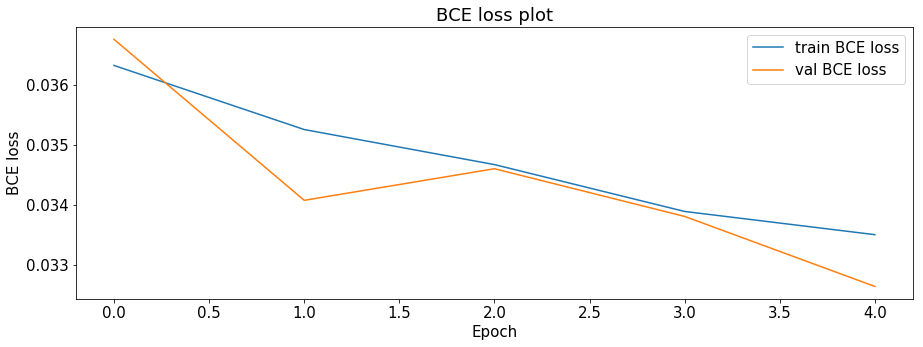

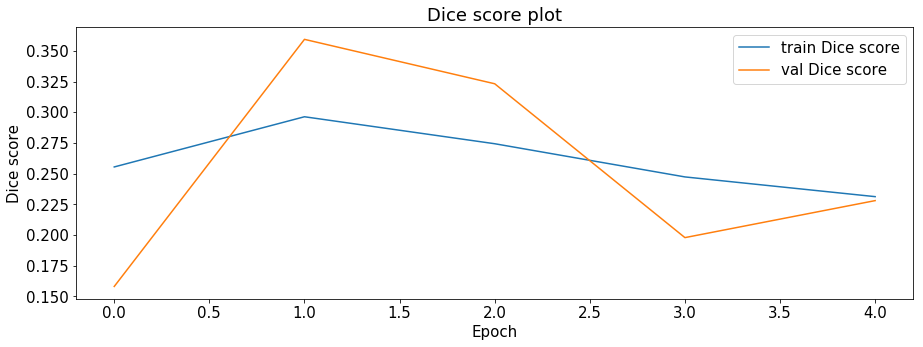

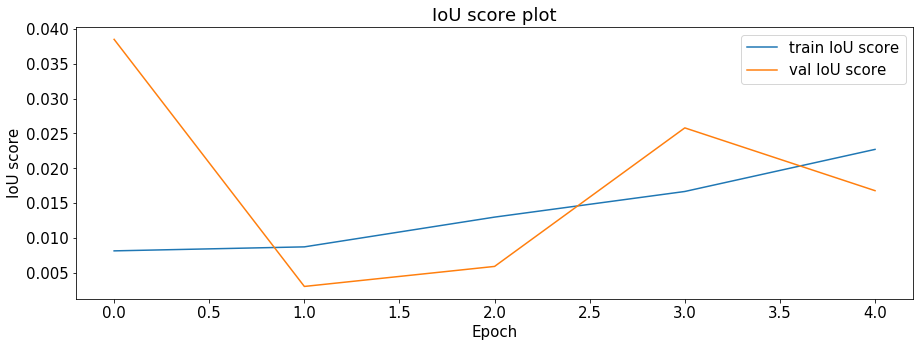

In [22]:
# PLOT TRAINING 
losses_base = base_trainer.losses
dice_scores_base = base_trainer.dice_scores # overall dice
iou_scores_base = base_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses_base, "BCE loss")
plot(dice_scores_base, "Dice score")
plot(iou_scores_base, "IoU score")

## Superior Unet

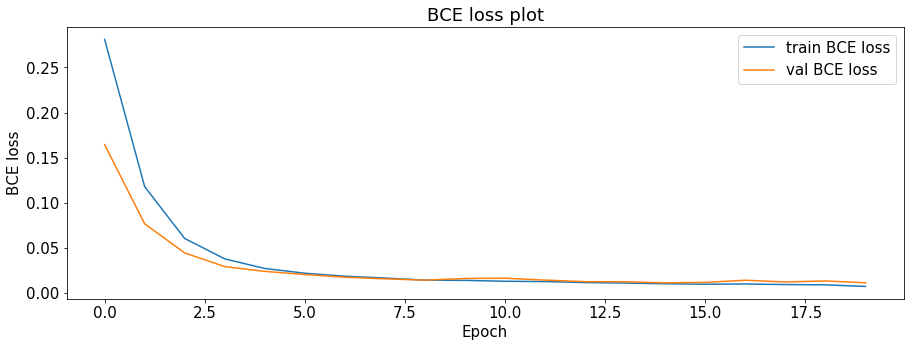

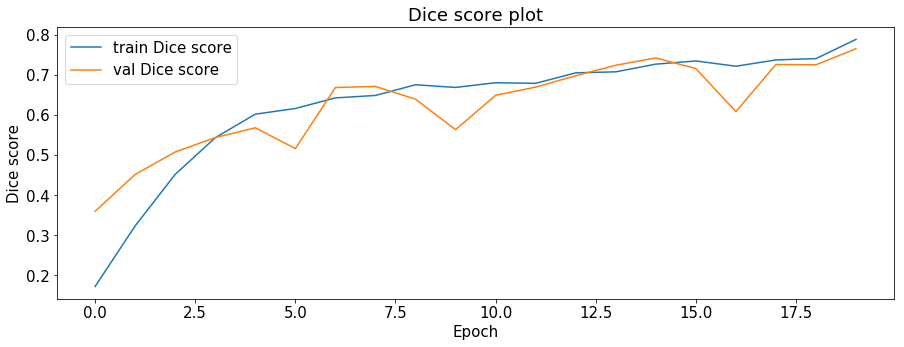

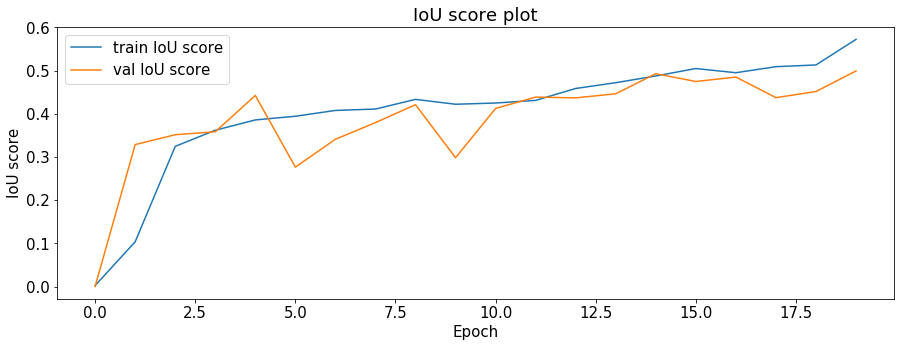

In [19]:
# PLOT TRAINING 
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

# Testing and predictions

In [23]:
# What this is doing? please refer to my above linked kernel
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null
package_path = '../input/unetmodelscript'
import sys
sys.path.append(package_path)

In [24]:
import os
import pandas as pd
import shutil

# Define the path to the current images directory
current_images_directory = "/kaggle/input/severstal-steel-defect-detection/train_images"  # Adjust this path as needed

# Load the train.csv file
train_df = pd.read_csv('/kaggle/input/steelsudo1/sudo.csv', engine='python')  # Adjust the file path as per your directory structure

# Select the first 2000 rows without filtering out nulls
first_2000_rows = train_df.head(2000)

# Extract unique image names from these rows
unique_images = first_2000_rows['ImageId_ClassId'].apply(lambda x: x.split('_')[0]).unique()

# Create a new DataFrame to store annotations for only the unique images
selected_images_new_df = first_2000_rows[first_2000_rows['ImageId_ClassId'].apply(lambda x: x.split('_')[0]).isin(unique_images)]

# Ensure the DataFrame has the columns 'ImageId_ClassId' and 'EncodedPixels'
selected_images_new_df = selected_images_new_df[['ImageId_ClassId', 'EncodedPixels']].copy()

# Create a new directory to store selected images
output_directory = 'selected_images2'
os.makedirs(output_directory, exist_ok=True)

# Copy unique images to the new directory
for image_filename in unique_images:
    image_source_path = os.path.join(current_images_directory, image_filename)
    image_dest_path = os.path.join(output_directory, image_filename)
    if os.path.exists(image_source_path):  # Check if the source image exists before copying
        shutil.copy(image_source_path, image_dest_path)

# Save the DataFrame with selected images and encoded pixels to a new CSV file
selected_images_new_df.to_csv('selected_images_annotations2.csv', index=False)


In [45]:
import os
import pandas as pd
import shutil
import random

# Define the path to the current images directory
current_images_directory = "/kaggle/input/severstal-steel-defect-detection/train_images"  # Replace "path_to_current_images_directory" with the actual path

# Load the train.csv file
train_df = pd.read_csv('/kaggle/input/steelsudo1/sudo.csv', engine='python')  # Adjust the file path as per your directory structure

# Filter out rows where encoded pixels are not NaN
train_df_filtered = train_df.dropna(subset=['EncodedPixels'])

# Randomly select 100 images
random.seed(75)  # Set a seed for reproducibility
selected_rows = random.sample(range(len(train_df_filtered)), 1000)
selected_images_df = train_df_filtered.iloc[selected_rows]

# Create a new DataFrame with selected image IDs, class IDs, and encoded pixels
selected_images_new_df = selected_images_df[['ImageId_ClassId', 'EncodedPixels']].copy()

# Create a new directory to store selected images
output_directory = 'selected_images'
os.makedirs(output_directory, exist_ok=True)

# Copy selected images to the new directory
for index, row in selected_images_df.iterrows():
    image_filename = row['ImageId_ClassId'].split('_')[0]  # Assuming image filenames are based on image IDs
    image_source_path = os.path.join(current_images_directory, image_filename)
    image_dest_path = os.path.join(output_directory, image_filename)
    shutil.copy(image_source_path, image_dest_path)

# Save the DataFrame with selected images and encoded pixels to a new CSV file
selected_images_new_df.to_csv('selected_images_annotations.csv', index=False)


In [25]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        df['ImageId'] = df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [26]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [29]:
!ls /kaggle/input/trainedunetmodel

model.pth


In [30]:
sample_submission_path = '/kaggle/working/selected_images_annotations2.csv'
test_data_folder = "/kaggle/working/selected_images2"

In [31]:
# initialize test dataloader
best_threshold = 0.5
num_workers = 2
batch_size = 4
print('best_threshold', best_threshold)
min_size = 3500
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

best_threshold 0.5


In [32]:
# Initialize mode and load trained weights
ckpt_path = "/kaggle/input/trainedunetmodel/model.pth"
device = torch.device("cuda")
model = Unet("resnet18", encoder_weights=None, classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [33]:
# start prediction
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])



In [34]:
# save predictions to predections.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
#df['EncodedPixels'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
#df = df.dropna(subset=['EncodedPixels']).copy()

# Reset the index of the new DataFrame
#df.reset_index(drop=True, inplace=True)
df.to_csv("predictions2.csv", index=False)

In [35]:
df.head()

ImageId_ClassId EncodedPixels
0  0002cc93b.jpg_1              
1  0002cc93b.jpg_2              
2  0002cc93b.jpg_3              
3  0002cc93b.jpg_4              
4  00031f466.jpg_1

In [ ]:
test_dataset = pd.read_csv('/kaggle/working/selected_images_annotations.csv')

In [37]:
import numpy as np
import pandas as pd

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def decode_rle(encoded_pixels, height, width):
    '''
    Decode RLE encoded pixels to binary mask
    '''
    mask = np.zeros(height*width, dtype=np.uint8)
    encoded_pixels = encoded_pixels.split()
    for i in range(0, len(encoded_pixels), 2):
        start = int(encoded_pixels[i]) - 1
        length = int(encoded_pixels[i+1])
        mask[start:start+length] = 1
    return mask.reshape((height, width))

def calculate_dice(pred_mask, true_mask):
    '''
    Calculate Dice score for two binary masks
    '''
    intersection = np.sum(pred_mask * true_mask)
    dice = (2. * intersection) / (np.sum(pred_mask) + np.sum(true_mask))
    return dice

def calculate_iou(pred_mask, true_mask):
    '''
    Calculate IoU for two binary masks
    '''
    intersection = np.sum(pred_mask * true_mask)
    union = np.sum(pred_mask) + np.sum(true_mask) - intersection
    iou = intersection / union
    return iou

# Load test dataset and predicted DataFrame
test_dataset = pd.read_csv('/kaggle/working/selected_images_annotations2.csv')  # Replace 'test_annotations.csv' with your test dataset file path
predicted_df = df.copy()  # Replace 'predicted_results.csv' with your predicted DataFrame

# Merge predictions with test dataset based on image IDs
merged_df = pd.merge(test_dataset, predicted_df, on='ImageId_ClassId')


In [41]:
# save predictions to submission.csv

#merged_df['EncodedPixels'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
merged_df = df.dropna(subset=['EncodedPixels_y']).copy()

# Reset the index of the new DataFrame
merged_df.reset_index(drop=True, inplace=True)
#df.to_csv("predictions2.csv", index=False)

KeyError: ['EncodedPixels_y']

In [43]:
merged_df = df.dropna(subset=['EncodedPixels_y']).copy()


KeyError: ['EncodedPixels_y']

In [42]:
print(merged_df.columns)


Index(['ImageId_ClassId', 'EncodedPixels_x', 'EncodedPixels_y'], dtype='object')


In [44]:
merged_df.head()

ImageId_ClassId                                    EncodedPixels_x  \
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
1  0002cc93b.jpg_2                                                NaN   
2  0002cc93b.jpg_3                                                NaN   
3  0002cc93b.jpg_4                                                NaN   
4  00031f466.jpg_1                                                NaN   

  EncodedPixels_y  
0                  
1                  
2                  
3                  
4